In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

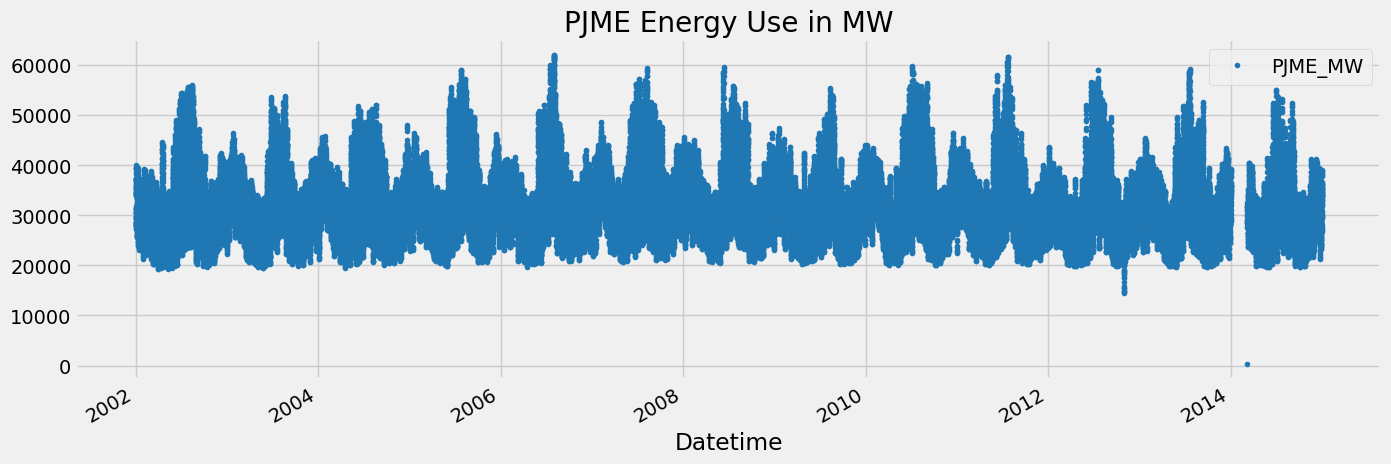

In [4]:
df.plot(style='.',
figsize=(15, 5),
color=color_pal[0],
title='PJME Energy Use in MW')

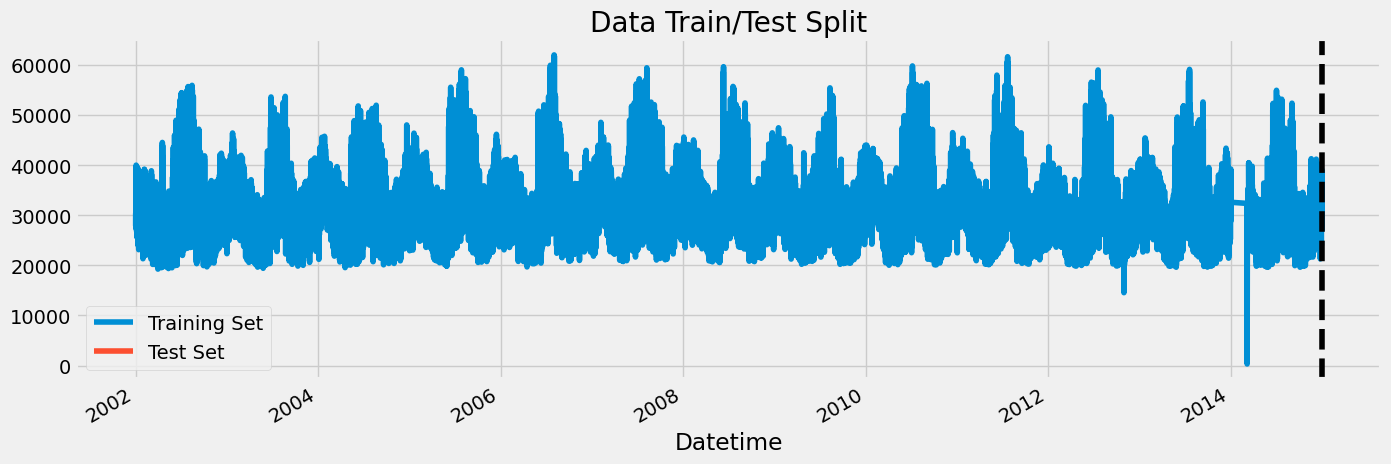

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])


Text(0.5, 1.0, 'Week Of Data')

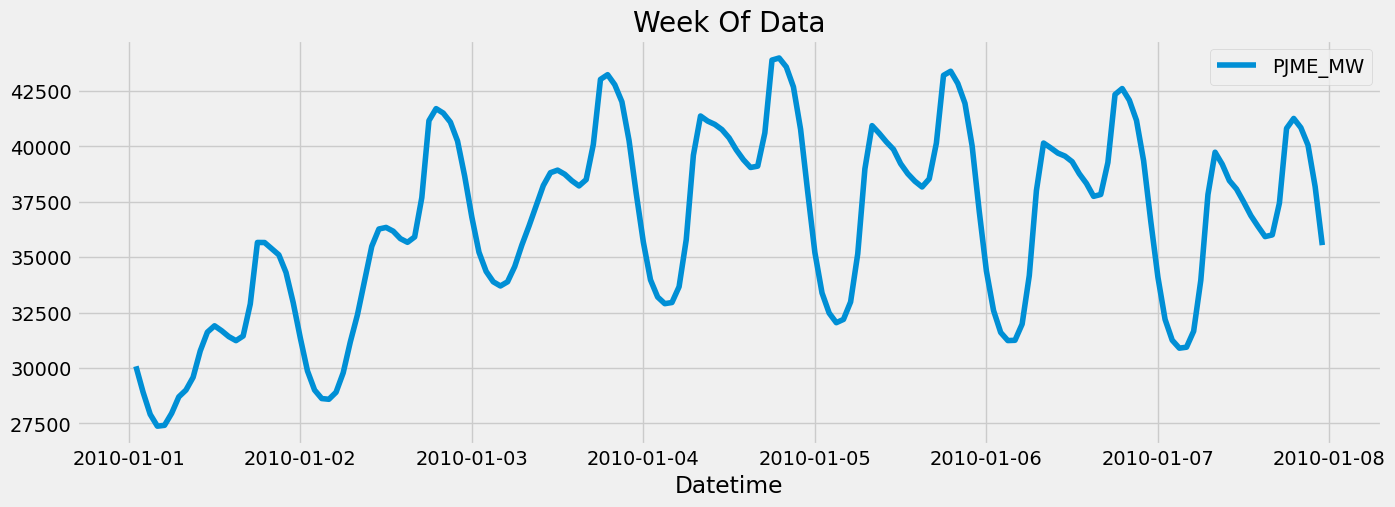

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')])
plt.title('Week Of Data')

In [7]:
def create_features(df):
 df = df.copy()
 df['hour'] = df.index.hour
 df['dayofweek'] = df.index.dayofweek
 df['quarter'] = df.index.quarter
 df['month'] = df.index.month
 df['year'] = df.index.year
 df['dayofyear'] = df.index.dayofyear
 df['dayofmonth'] = df.index.day
 df['weekofyear'] = df.index.isocalendar().week
 return df

Text(0.5, 1.0, 'MW By Hour')

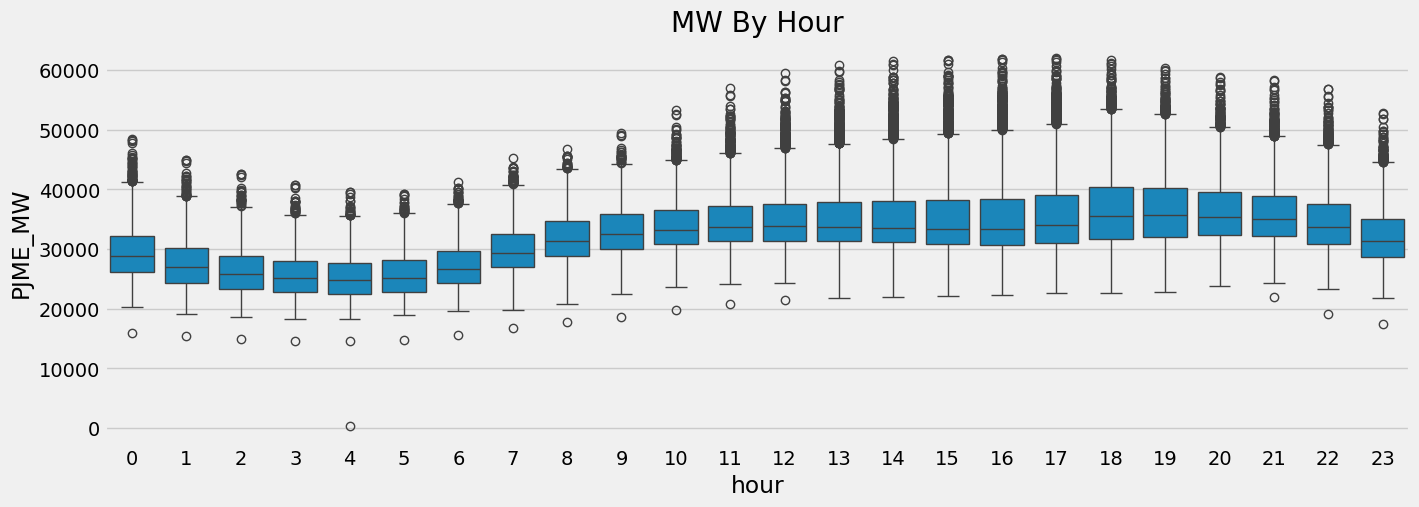

In [8]:
df = create_features(df)
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='hour',y='PJME_MW')
ax.set_title('MW By Hour')

Text(0.5, 1.0, 'MW By Month')

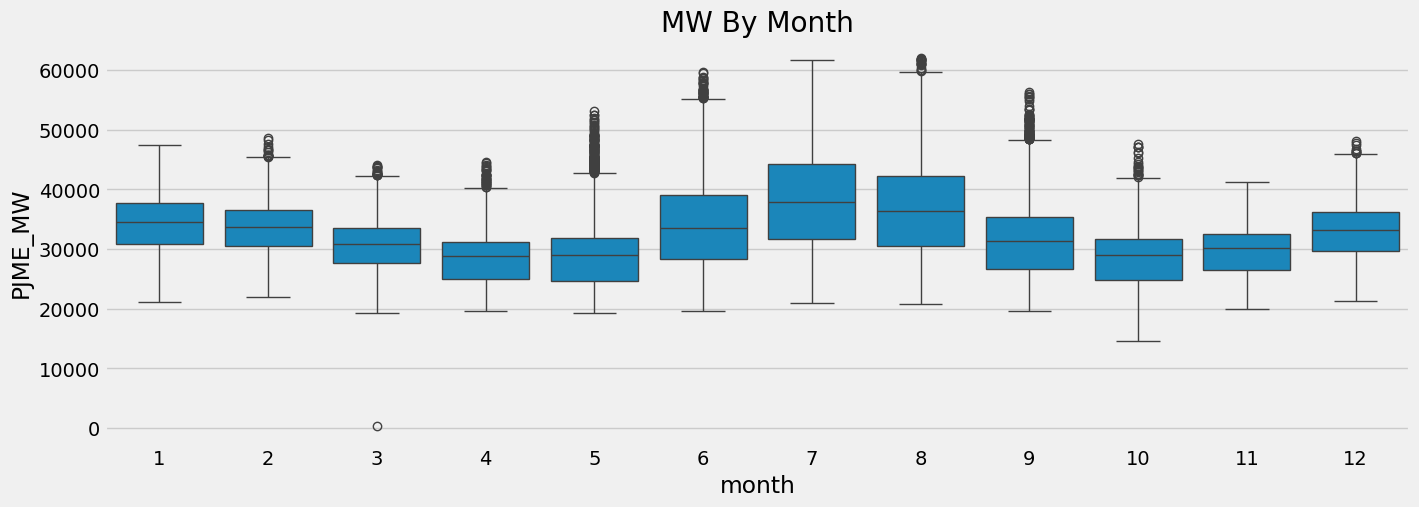

In [9]:

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='month',y='PJME_MW')
ax.set_title('MW By Month')

In [10]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour','dayofweek','month','quarter','dayofyear','year','dayofmonth','weekofyear']
TARGET= 'PJME_MW'
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds=50,learning_rate = 0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)])

[0]	validation_0-rmse:6415.66925	validation_1-rmse:582.84764
[1]	validation_0-rmse:6371.11958	validation_1-rmse:602.75194
[2]	validation_0-rmse:6327.21101	validation_1-rmse:622.45898
[3]	validation_0-rmse:6283.81082	validation_1-rmse:641.97070
[4]	validation_0-rmse:6240.95570	validation_1-rmse:661.28906
[5]	validation_0-rmse:6198.73185	validation_1-rmse:680.41603
[6]	validation_0-rmse:6157.02247	validation_1-rmse:699.35352
[7]	validation_0-rmse:6115.83343	validation_1-rmse:718.10156
[8]	validation_0-rmse:6075.24661	validation_1-rmse:736.66406
[9]	validation_0-rmse:6035.16395	validation_1-rmse:755.04296
[10]	validation_0-rmse:5995.60866	validation_1-rmse:757.85936
[11]	validation_0-rmse:5956.58169	validation_1-rmse:775.98828
[12]	validation_0-rmse:5918.12060	validation_1-rmse:780.51173
[13]	validation_0-rmse:5879.79253	validation_1-rmse:798.39844
[14]	validation_0-rmse:5842.34282	validation_1-rmse:802.81446
[15]	validation_0-rmse:5804.85839	validation_1-rmse:822.63867
[16]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'Features Importances')

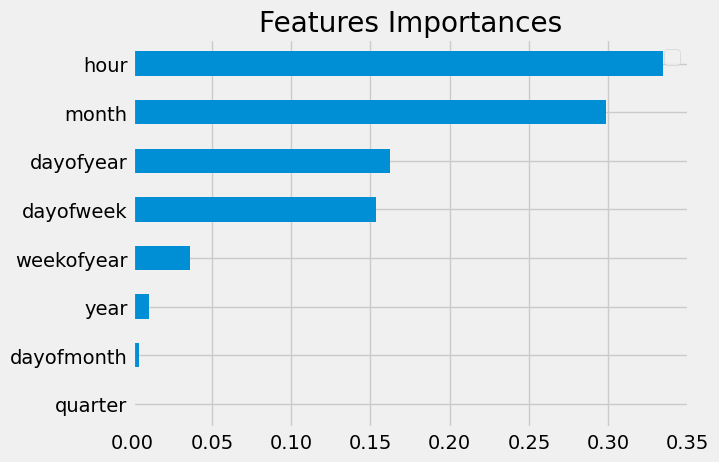

In [11]:
feature_importances = pd.DataFrame(data=reg.feature_importances_,index = reg.feature_names_in_,columns=['importances'])
feature_importances = feature_importances.sort_values(by = 'importances',ascending=1)
feature_importances.plot(kind='barh')
plt.legend('')
plt.title('Features Importances')

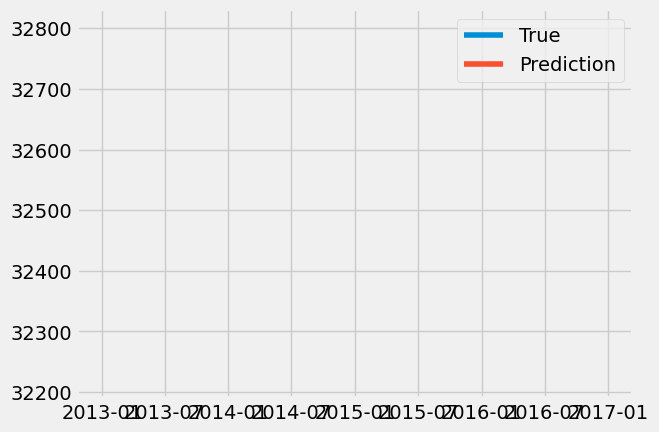

In [12]:
test['prediciton'] = reg.predict(X_test)
plt.plot(test['PJME_MW'],label='True')
plt.plot(test['prediciton'],label='Prediction')
plt.legend()

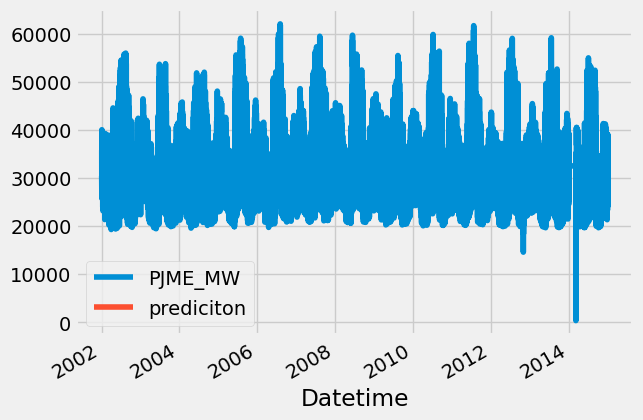

In [13]:
df['PJME_MW'].plot()
test['prediciton'].plot()
plt.legend()

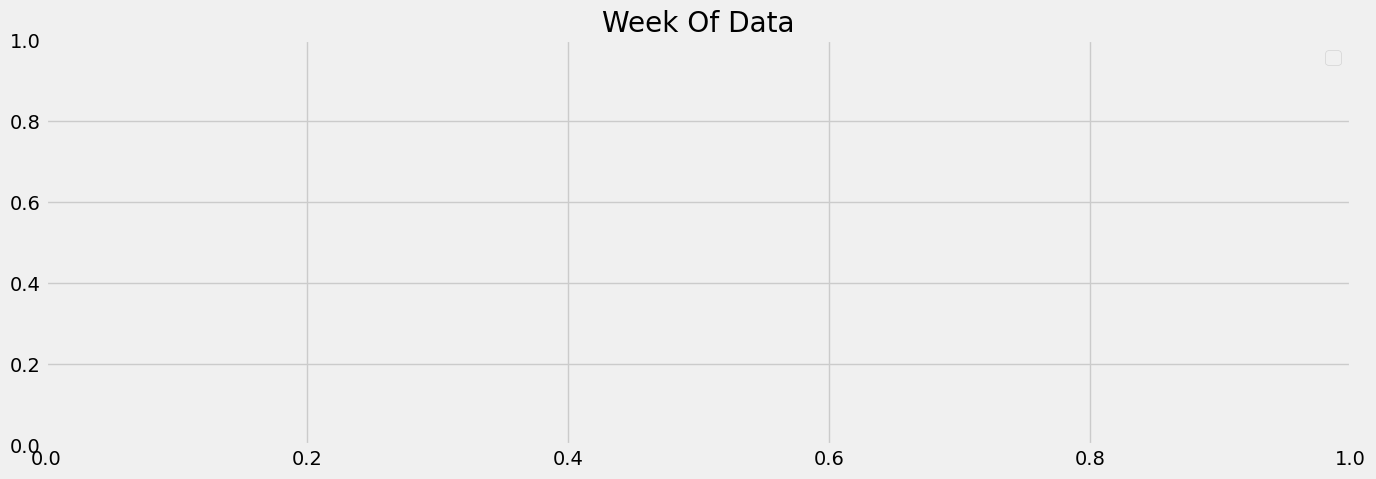

In [14]:
filtered_data = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]
# Plotting
plt.figure(figsize=(15, 5))
sns.lineplot(data=filtered_data['PJME_MW'], marker='o', label='Truth Data')
sns.scatterplot(data=filtered_data['prediciton'], marker='.', label='Prediction',color='red')
plt.title('Week Of Data')
plt.legend()
plt.show()

In [15]:
mean_squared_error(test['PJME_MW'],test['prediciton'])
13972551.445122646
test['error'] = test['PJME_MW'] - test['prediciton']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
.mean()[['PJME_MW','prediciton','error','abs_error']]
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

,,,PJME_MW,prediciton,error,abs_error
year,month,dayofmonth,,,,
2015,1,1,32802.0,32219.152344,582.847656,582.847656


In [16]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

,,,PJME_MW,prediciton,error,abs_error
year,month,dayofmonth,,,,
2015,1,1,32802.0,32219.152344,582.847656,582.847656


In [17]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,PJME_MW,prediciton,error,abs_error
year,month,dayofmonth,,,,
2015,1,1,32802.0,32219.152344,582.847656,582.847656
